# Assignment 1

Mathia Quimpo, Matthew Chin, Wanqiu Zhang

## Exploration and Preprocessing

In [39]:
import pandas as pd
import numpy as np
import re
import os
import requests
import string
import nltk
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import accuracy_score
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
import matplotlib.pyplot as plt

In [2]:
# Load dataset
file_path = os.path.expanduser("~/Desktop/School/6200/Project/IMDB_Dataset.csv")  
df = pd.read_csv(file_path)

print(df.head())

                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


In [3]:
# Display column names
print("Columns in the dataset:\n", df.columns)

Columns in the dataset:
 Index(['review', 'sentiment'], dtype='object')


In [4]:
# Get general info
print(df.info())

# Descriptive statistics
print(df.describe())

# Check for missing values
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB
None
                                                   review sentiment
count                                               50000     50000
unique                                              49582         2
top     Loved today's show!!! It was a variety and not...  positive
freq                                                    5     25000
review       0
sentiment    0
dtype: int64


In [5]:
# Display the entire review text 
pd.set_option('display.max_colwidth', None)

In [6]:
# Add a new column for text length
df["Text_Length"] = df["review"].astype(str).apply(len)

# Display descriptive statistics for text length
print(df["Text_Length"].describe())

count    50000.000000
mean      1309.431020
std        989.728014
min         32.000000
25%        699.000000
50%        970.000000
75%       1590.250000
max      13704.000000
Name: Text_Length, dtype: float64


In [7]:
# Read a few random review samples
print(df["review"].sample(5, random_state=45))

42462                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   This movie was an absolute waste of time. It's nothing but a wanna-be gangster movie. It contains a very predictable plot. My feelings are unsympathetic to the characters, and the dialogue is mediocre at best. Half the time you are looking for something else to do, because the movie is that boring, since you already know what's going to happen. The other half of the time you're desperately hoping the protagonist grows a pair of balls or just ends his life by jumping off a bridge or something. Also, the secondary characters

In [8]:
# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

In [23]:
# Text cleaning function
def clean_text(review):
    if not isinstance(review, str):
        return ""  # Handle missing values
    
    # 1. Remove HTML tags using a regex pattern
    review = re.sub(r"<.*?>", "", review)  # Remove HTML tags

    # 2. Replace URLs with a placeholder "URL"
    review = re.sub(r'http[s]?://\S+', 'URL', review)

    # 3. Convert to lowercase
    review = review.lower()

    # 4. Normalize whitespace (remove any leftover <br /> or extra spaces)
    review = re.sub(r"\s+", " ", review).strip()

    # 5. Remove special characters, numbers, and punctuation
    review = re.sub(r"[^a-z\s]", "", review)

    # 6. Tokenize the text into words
    words = word_tokenize(review)

    # 7. Remove stopwords
    words = [word for word in words if word not in stop_words]
    
    # 8. Lemmatize the tokens
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]

    # 9. Convert back to string
    cleaned_text = " ".join(lemmatized_words)
    
    return cleaned_text, lemmatized_words

In [25]:
# Select 100 random rows
random_sample = df.sample(100)

In [26]:
# Apply text cleaning
random_sample[["cleaned_text", "tokens"]] = random_sample["review"].apply(clean_text).apply(pd.Series)

In [27]:
# Spot-checking
spotcheck_sample = random_sample[["review", "cleaned_text"]].sample(5, random_state=45)
print(spotcheck_sample)

In [28]:
# Function to generate bigrams and trigrams
def generate_ngrams(text, n=2):
    tokens = word_tokenize(text.lower())  
    n_grams = list(ngrams(tokens, n))  
    return ["_".join(gram) for gram in n_grams]  

# Generate bigrams and trigrams
random_sample["Bigrams"] = random_sample["cleaned_text"].apply(lambda x: generate_ngrams(x, 2) if isinstance(x, str) else [])
random_sample["Trigrams"] = random_sample["cleaned_text"].apply(lambda x: generate_ngrams(x, 3) if isinstance(x, str) else [])

# Check the results
print(random_sample[["review", "cleaned_text", "Bigrams", "Trigrams"]].sample(5))

## TF-IDF Vectorizer

In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TfidfVectorizer for unigrams, bigrams, and trigrams
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 3))

# Fit and transform the cleaned text from random_sample to create features
X_tfidf = tfidf_vectorizer.fit_transform(random_sample["cleaned_text"])

# Display the shape of the feature matrix
print(f"Feature matrix shape: {X_tfidf.shape}")

Feature matrix shape: (100, 25419)


In [35]:
y = random_sample['sentiment']
# Split data into training and testing sets (80% train, 20% test)
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train_tfidf.shape}")
print(f"Test set size: {X_test_tfidf.shape}")

Training set size: (80, 25419)
Test set size: (20, 25419)


## Logistic Regression

In [40]:
# Initialize the Logistic Regression model
log_reg_tfidf = LogisticRegression(max_iter=1000)

# Train the model
log_reg_tfidf.fit(X_train_tfidf, y_train)

# Make predictions
y_pred_log_reg_tfidf = log_reg_tfidf.predict(X_test_tfidf)

# Evaluate the model
print("Logistic Regression (TF-IDF) Classification Report:")
print(classification_report(y_test, y_pred_log_reg_tfidf))

Logistic Regression (TF-IDF) Classification Report:
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00        10
    positive       0.50      1.00      0.67        10

    accuracy                           0.50        20
   macro avg       0.25      0.50      0.33        20
weighted avg       0.25      0.50      0.33        20



/Users/mayi/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mayi/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mayi/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Naive-Bayes

In [41]:
# Initialize the Naive Bayes model
nb_tfidf = MultinomialNB()

# Train the model
nb_tfidf.fit(X_train_tfidf, y_train)

# Make predictions
y_pred_nb_tfidf = nb_tfidf.predict(X_test_tfidf)

# Evaluate the model
print("Naive Bayes (TF-IDF) Classification Report:")
print(classification_report(y_test, y_pred_nb_tfidf))


Naive Bayes (TF-IDF) Classification Report:
              precision    recall  f1-score   support

    negative       1.00      0.10      0.18        10
    positive       0.53      1.00      0.69        10

    accuracy                           0.55        20
   macro avg       0.76      0.55      0.44        20
weighted avg       0.76      0.55      0.44        20



## TextBlob

In [134]:
def analyze_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity, blob.sentiment.subjectivity, 'Positive' if blob.sentiment.polarity > 0.05 else ('Negative' if blob.sentiment.polarity < -0.05 else 'Neutral')

# Apply the function and append new columns
random_sample[['TextBlob_Polarity', 'TextBlob_Subjectivity', 'TextBlob_Sentiment']] = random_sample['Cleaned_Text'].apply(lambda x: pd.Series(analyze_sentiment(x)))

# Display the updated DataFrame
random_sample

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,...,Trigrams,Word_Count,Unique_Word_Count,Avg_Word_Length,Sentiment_Score,Sentiment_Label,VADER_Sentiment,TextBlob_Polarity,TextBlob_Subjectivity,TextBlob_Sentiment
69313,69314,B000FD78IO,A2442VURCNE01O,djanes1,2,3,1,1284508800,Don't Buy,"I tried these as a cheaper alternative to the Roland anchovies I usually buy (those were out of stock). The tins arrived bulging, and burst when opened. The contents smelled vomitous. Amazon shouldn't sell this unsuitable product, but until then you had best heed this and other negative reviews.",...,"[tried_cheaper_alternative, cheaper_alternative_roland, alternative_roland_anchovy, roland_anchovy_usually, anchovy_usually_buy, usually_buy_stock, buy_stock_tin, stock_tin_arrived, tin_arrived_bulging, arrived_bulging_burst, bulging_burst_opened, burst_opened_content, opened_content_smelled, content_smelled_vomitous, smelled_vomitous_amazon, vomitous_amazon_shouldnt, amazon_shouldnt_sell, shouldnt_sell_unsuitable, sell_unsuitable_product, unsuitable_product_best, product_best_heed, best_heed_negative, heed_negative_review]",25.0,25.0,6.320000,0.2960,Positive,Positive,0.150000,0.316667,Positive
37652,37653,B002R81L92,A1A3RPTIPAK4ON,womenfly,0,0,5,1350432000,very tasty,bought these at costco for a few cents less and figure they will either double in price or never be in stock again glad to know they are here on amazon They ARE addictingly good..the deep dark chocolate flavor is haunting. I was looking for choc cherries but these will do nicely,...,"[bought_costco_cent, costco_cent_le, cent_le_figure, le_figure_either, figure_either_double, either_double_price, double_price_never, price_never_stock, never_stock_glad, stock_glad_know, glad_know_amazon, know_amazon_addictingly, amazon_addictingly_goodthe, addictingly_goodthe_deep, goodthe_deep_dark, deep_dark_chocolate, dark_chocolate_flavor, chocolate_flavor_haunting, flavor_haunting_looking, haunting_looking_choc, looking_choc_cherry, choc_cherry_nicely]",24.0,24.0,5.708333,0.0052,Neutral,Neutral,0.190000,0.560000,Positive
177477,177478,B004U49QU2,A2BPB05QNCE00B,Stacey B.,0,0,5,1308700800,Delicious,"These cookies are so tasty! When I got them they were a little melted from shipping in the hot sun, so I put them in the fridge. When I pulled them out and ate them cold they were really great. I have a HUGE sweet tooth and I was pleasantly surprised to find out that these cookies were enough to satisfy it. My only complaint is that I expected the fudge in the center of the cookies to be more liquidy because of the packaging which says 'chewy gooey' but they were still delicious and I would purchase them again. I received both this flavor and the Chocofudge. They were both great, but I prefer the chocofudge better.",...,"[cooky_tasty_got, tasty_got_little, got_little_melted, little_melted_shipping, melted_shipping_hot, shipping_hot_sun, hot_sun_put, sun_put_fridge, put_fridge_pulled, fridge_pulled_ate, pulled_ate_cold, ate_cold_really, cold_really_great, really_great_huge, great_huge_sweet, huge_sweet_tooth, sweet_tooth_pleasantly, tooth_pleasantly_surprised, pleasantly_surprised_find, surprised_find_cooky, find_cooky_enough, cooky_enough_satisfy, enough_satisfy_complaint, satisfy_complaint_expected, complaint_expected_fudge, expected_fudge_center, fudge_center_cooky, center_cooky_liquidy, cooky_liquidy_packaging, liquidy_packaging_say, packaging_say_chewy, say_chewy_gooey, chewy_gooey_still, gooey_still_delicious, still_delicious_would, delicious_would_purchase, would_purchase_received, purchase_received_flavor, received_flavor_chocofudge, flavor_chocofudge_great, chocofudge_great_prefer, great_prefer_chocofudge, prefer_chocofudge_better]",45.0,41.0,5.933333,0.9765,Positive,Positive,0.208036,0.642857,Positive
501290,501291,B000LKZ4W8,A3HZ48A3WZ1CR7,Jen G,2,2,5,1288310400,Sugar Free and Super Good!,"These sugar free caramels are 60 calories and taste ju

In [135]:
# Spot-check several examples
spotcheck_sample = random_sample[['Text','VADER_Sentiment', 'TextBlob_Sentiment']].sample(5)
print(spotcheck_sample)

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   Text  \
362166                                                                                                                                                                                                                                                                                                                                                                       

In [136]:
# To manually review the sentiment, you can check the first few examples
for idx, row in spotcheck_sample.iterrows():
    print(f"Review Text: {row['Text']}")
    print(f"VADER Sentiment: {row['VADER_Sentiment']}")
    print(f"TextBlob_Sentiment: {row['TextBlob_Sentiment']}")
    print("-" * 50)

Review Text: I like this dark roast coffee, I make the large cup and it is still flavorful
VADER Sentiment: Positive
TextBlob_Sentiment: Neutral
--------------------------------------------------
Review Text: With so many to choose from, this product is becoming harder to find at the store.  Ordering it here was the easiest and fastest way to get it.  Love this product!  Tried several brands, but Folgers has the best combination of ingredients to make it cafe-quality.  Add nonfat half & half and/or nonfat ice cream and your cappuccino will be every bit as good as cafe-purchased--and you'll save a fortune in money and calories.  Shelf-life is good, so buy it by the case and you won't have to worry about running out.  Can't go a day without my mocha-cap fix!  On a hot day I add nonfat chocolate ice cream and I'm in Heaven!
VADER Sentiment: Positive
TextBlob_Sentiment: Positive
--------------------------------------------------
Review Text: Taste is as good as all the reviews. But not for

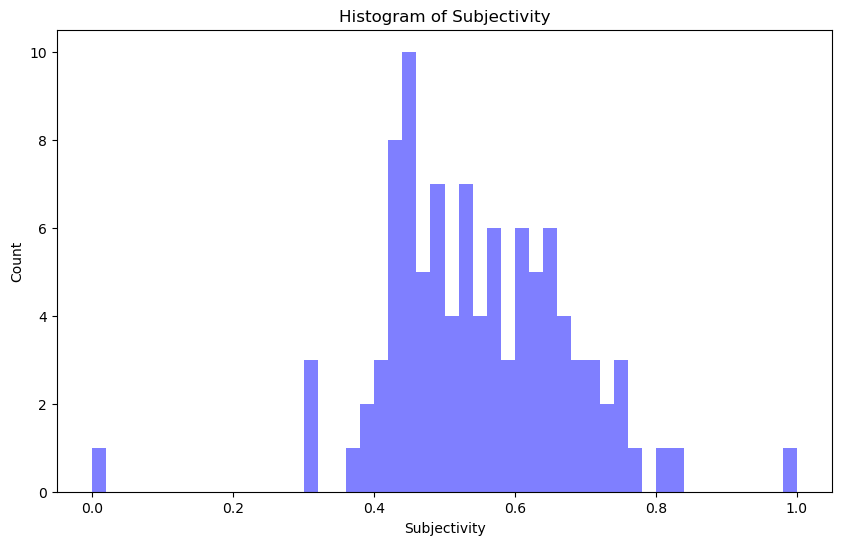

In [138]:
#Draw a histogram that shows the distribution of subjectivity: Count vs. subjectivity
num_bins = 50
plt.figure(figsize=(10,6))
n, bins, patches = plt.hist(random_sample.TextBlob_Subjectivity, num_bins, facecolor='blue', alpha=0.5)
plt.xlabel('Subjectivity')
plt.ylabel('Count')
plt.title('Histogram of Subjectivity')
plt.show()

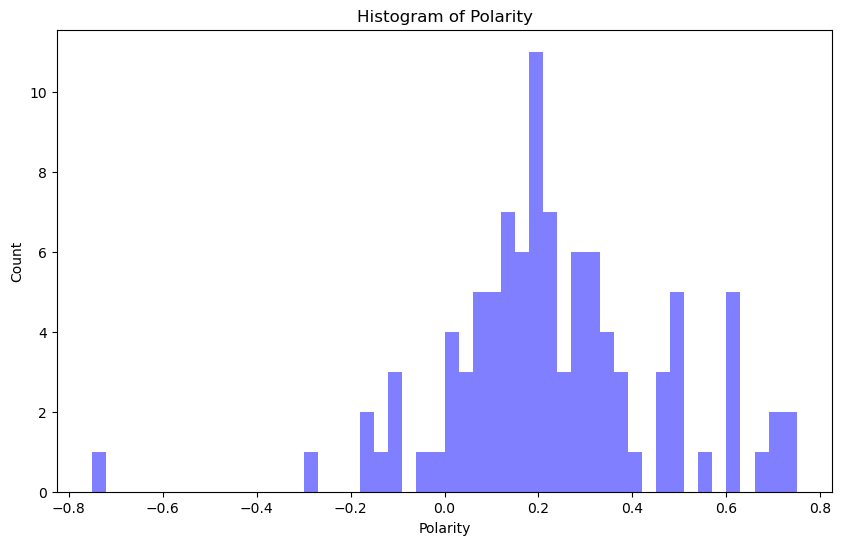

In [139]:
#Draw a histogram that shows the distribution of polarity: Count vs. polarity
num_bins = 50
plt.figure(figsize=(10,6))
n, bins, patches = plt.hist(random_sample.TextBlob_Polarity, num_bins, facecolor='blue', alpha=0.5)
plt.xlabel('Polarity')
plt.ylabel('Count')
plt.title('Histogram of Polarity')
plt.show()

## Analyze and Review

In [141]:
for idx, row in random_sample.iterrows():
    print(f"Review Text: {row['Text']}")
    print(f"VADER Sentiment: {row['VADER_Sentiment']}")
    print(f"TextBlob_Sentiment: {row['TextBlob_Sentiment']}")
    print("-" * 50)

Review Text: I tried these as a cheaper alternative to the Roland anchovies I usually buy (those were out of stock).  The tins arrived bulging, and burst when opened.  The contents smelled vomitous.  Amazon shouldn't sell this unsuitable product, but until then you had best heed this and other negative reviews.
VADER Sentiment: Positive
TextBlob_Sentiment: Positive
--------------------------------------------------
Review Text: bought these at costco for a few cents less and figure they will either double in price or never be in stock again glad to know they are here on amazon  They ARE addictingly good..the deep dark chocolate flavor is haunting.  I was looking for choc cherries but these will do nicely
VADER Sentiment: Neutral
TextBlob_Sentiment: Positive
--------------------------------------------------
Review Text: These cookies are so tasty! When I got them they were a little melted from shipping in the hot sun, so I put them in the fridge. When I pulled them out and ate them col

In [142]:
# Find cases where models disagree
disagreed_df = random_sample[random_sample["VADER_Sentiment"] != random_sample["TextBlob_Sentiment"]]
print("\n Examples where models disagree (need manual review):")
print("-" * 50)
for idx, row in disagreed_df.iterrows():
    print(f"Review Text: {row['Text']}")
    print(f"VADER Sentiment: {row['VADER_Sentiment']}")
    print(f"TextBlob_Sentiment: {row['TextBlob_Sentiment']}")
    print("-" * 50)


 Examples where models disagree (need manual review):
--------------------------------------------------
Review Text: bought these at costco for a few cents less and figure they will either double in price or never be in stock again glad to know they are here on amazon  They ARE addictingly good..the deep dark chocolate flavor is haunting.  I was looking for choc cherries but these will do nicely
VADER Sentiment: Neutral
TextBlob_Sentiment: Positive
--------------------------------------------------
Review Text: Ordered this package along with some other 'decades' selection. The diversity wasn't bad, but I found a lot of the candy to be stale - as if it was the actual candy from that era, sitting in some candy vault for all these years. The candy that was supposed to be chewy was hard, and some selections (Bit O' Honey, Abbazabba, Turkish Taffy, etc...) had obviously been kept in a hot, humid area because they had melted and hardened into odd unappealing shapes. The hard candy (that w

In [143]:
# Find cases where models agree
agreed_df = random_sample[random_sample["VADER_Sentiment"] == random_sample["TextBlob_Sentiment"]]
print("Examples where models agree (likely correct):")
print("-" * 50)
for idx, row in agreed_df.iterrows():
    print(f"Review Text: {row['Text']}")
    print(f"VADER Sentiment: {row['VADER_Sentiment']}")
    print(f"TextBlob_Sentiment: {row['TextBlob_Sentiment']}")
    print("-" * 50)

Examples where models agree (likely correct):
--------------------------------------------------
Review Text: I tried these as a cheaper alternative to the Roland anchovies I usually buy (those were out of stock).  The tins arrived bulging, and burst when opened.  The contents smelled vomitous.  Amazon shouldn't sell this unsuitable product, but until then you had best heed this and other negative reviews.
VADER Sentiment: Positive
TextBlob_Sentiment: Positive
--------------------------------------------------
Review Text: These cookies are so tasty! When I got them they were a little melted from shipping in the hot sun, so I put them in the fridge. When I pulled them out and ate them cold they were really great. I have a HUGE sweet tooth and I was pleasantly surprised to find out that these cookies were enough to satisfy it. My only complaint is that I expected the fudge in the center of the cookies to be more liquidy because of the packaging which says 'chewy gooey' but they were sti

In [149]:
# Use TextBlob's classification as a "baseline" and compare VADER against it
agreement_rate = accuracy_score(random_sample['VADER_Sentiment'], random_sample['TextBlob_Sentiment'])

print(f"Agreement Rate between VADER and TextBlob: {agreement_rate:.2f}")

Agreement Rate between VADER and TextBlob: 0.80


In [144]:
def get_vader_sentiment(text):
    score = analyzer.polarity_scores(str(text))["compound"]
    return "Positive" if score > 0.05 else "Negative" if score < -0.05 else "Neutral"
# Function to get sentiment labels from VADER

In [145]:
# Function to get sentiment labels from TextBlob
def get_textblob_sentiment(text):
    score = TextBlob(str(text)).sentiment.polarity
    return "Positive" if score > 0.05 else "Negative" if score < -0.05 else "Neutral"

In [146]:
#which model would you use and why?
import time

# Measure VADER speed
start_time = time.time()
random_sample["VADER_Sentiment"] = random_sample["Text"].apply(get_vader_sentiment)
vader_time = time.time() - start_time

# Measure TextBlob speed
start_time = time.time()
random_sample["TextBlob Sentiment"] = random_sample["Text"].apply(get_textblob_sentiment)
textblob_time = time.time() - start_time

# Compare models
comparison = {
    "Criteria": ["Speed", "Accuracy", "Interpretability", "Handling Sarcasm", "Ease of Use"],
    "VADER": [vader_time, "Good for strong emotions", "Easy to understand", "Struggles with sarcasm", "Very easy"],
    "TextBlob": [textblob_time, "Basic polarity analysis", "Simple", "Struggles with context", "Very easy"]
}

comparison_df = pd.DataFrame(comparison)
print("\n Model Comparison:")
print(comparison_df)


 Model Comparison:
           Criteria                     VADER                 TextBlob
0             Speed                  0.079173                 0.023821
1          Accuracy  Good for strong emotions  Basic polarity analysis
2  Interpretability        Easy to understand                   Simple
3  Handling Sarcasm    Struggles with sarcasm   Struggles with context
4       Ease of Use                 Very easy                Very easy


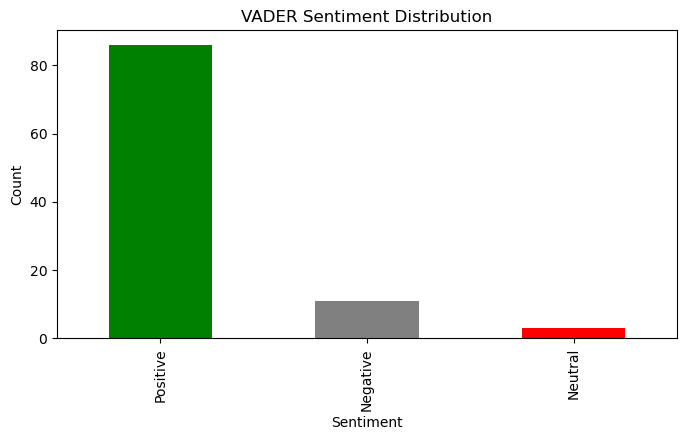

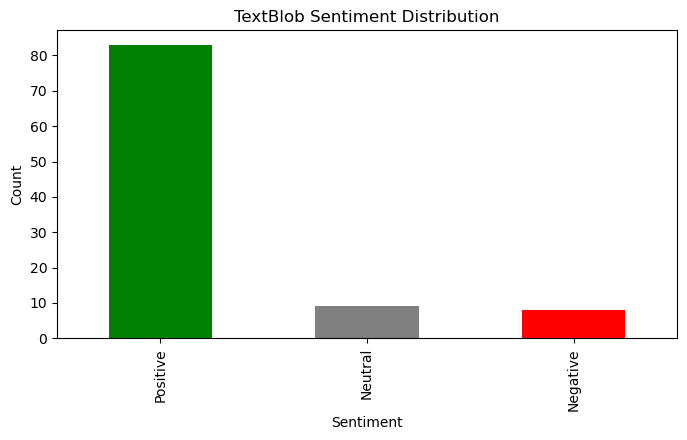

In [147]:
#visualize Sentiment Distribution
import matplotlib.pyplot as plt

# Count sentiment labels
vader_counts = random_sample["VADER_Sentiment"].value_counts()
textblob_counts = random_sample["TextBlob_Sentiment"].value_counts()

# Plot VADER Sentiment Distribution
plt.figure(figsize=(8, 4))
vader_counts.plot(kind='bar', color=['green', 'gray', 'red'])
plt.title("VADER Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

# Plot TextBlob Sentiment Distribution
plt.figure(figsize=(8, 4))
textblob_counts.plot(kind='bar', color=['green', 'gray', 'red'])
plt.title("TextBlob Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

In [150]:
#Questions: Do you agree with the models?
# we agree with the models(VADER and TextBlob), here are some key points: VADER is great for short, social media-like text and captures emotion-driven words well
#TextBlob has more rules and relies on world polarity, which might miss context and sarcasm

#if VADER and TextBlob both classify a review as "positive" or "negative", it is likely correct.
#if disagree, it suggests the text is more complex
#A neutral classfication might indicate mixed sentiments